In [41]:
import os
import glob
import json
import pandas as pd
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import skimage.io as io
from matplotlib import pyplot as plt
from pprint import pprint
import cv2 
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Conv2DTranspose
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pycocotools import mask as coco_mask 
%matplotlib inline

LOADING AND EXPLORING DATA

In [42]:
with open('dataSet/turtles-data/data/annotations.json', 'r', encoding='utf8') as file:
    annotations = json.load(file)

In [43]:
# initialise COCO API for annotations
coco = COCO('dataSet/turtles-data/data/annotations.json')

loading annotations into memory...
Done (t=15.98s)
creating index...
index created!


In [44]:
data = []
for img_id in range(1, 11):
    img = coco.loadImgs(img_id)[0]
    file_name = "dataSet/turtles-data/data/" + img['file_name']
    image = np.array(Image.open(file_name))

    # Get annotation information
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)

    # Create mask for annotations
    mask = coco.annToMask(anns[0])
    for ann in anns[1:]:
        mask += coco.annToMask(ann)

    # Append image and mask data to list
    data.append({'input': image, 'expected_mask': mask})

# Create DataFrame from the collected data
df = pd.DataFrame(data)


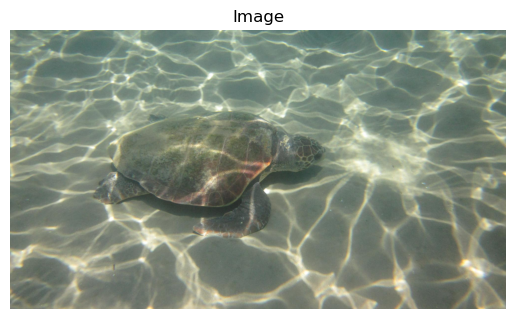

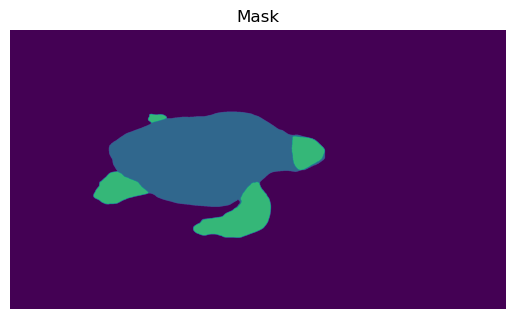

In [45]:
### JUST FOR TESTING IF THE MASK AND INPUT MATCHING IS CORRECT

img = df.iloc[8]['input']          # Get the first image
mask = df.iloc[8]['expected_mask'] # Get the first mask

# Display the image
plt.imshow(img)
plt.title('Image')
plt.axis('off')
plt.show()

# Display the mask
plt.imshow(mask)  # Use alpha for transparency
plt.title('Mask')
plt.axis('off')
plt.show()